In [31]:
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.preprocessing import RobustScaler
import statistics
import math

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
%ls

drive/  sample_data/


In [34]:
test = pd.read_csv("/content/drive/MyDrive/7313Project/test_reduced.csv")
train = pd.read_csv("/content/drive/MyDrive/7313Project/train_reduced.csv")
testn = pd.read_csv("/content/drive/MyDrive/7313Project/test_reduced.csv")
target = pd.read_csv("/content/drive/MyDrive/7313Project/target.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [35]:
train.drop(train.iloc[:, [0,1]], axis=1, inplace=True)
test.drop(test.iloc[:, [0,1]], axis=1, inplace=True)

In [36]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [37]:
train['is_cup'] = labelencoder.fit_transform(train['is_cup'])
test['is_cup'] = labelencoder.fit_transform(test['is_cup'])
target['target'].replace({"home": 0, "draw": 1, "away":2}, inplace=True)
train.drop(train.filter(regex='recorded_matches').columns, axis=1, inplace = True)
test.drop(test.filter(regex='recorded_matches').columns, axis=1, inplace = True)
train_x = train.copy()
train_y = target['target'].copy()
train_x.fillna(train_x.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

In [38]:
from sklearn.preprocessing import StandardScaler

#fit scaler on training data
norm = StandardScaler().fit(train_x)
#transform training data
xtrain_norm = norm.transform(train_x)
#transform testing data
test_norm = norm.transform(test)

In [39]:
!pip install lightgbm

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    xtrain_norm, train_y, test_size=0.2, random_state=2, stratify=train_y)

In [41]:
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
seed = 123
lgbm_params = {
    "objective":"multiclass",
    "boosting_type":"gbdt",
    'num_class':3,
    'metric': "multi_logloss",
    'learning_rate': 0.05,        
    'lambda_l1': 2,
    'lambda_l2': 7,
    'num_leaves': 400,
    'min_sum_hessian_in_leaf': 20,
    'feature_fraction': 0.5,
    'feature_fraction_bynode': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 42,
    'min_data_in_leaf': 1000,
    'max_depth': 5,
    'verbosity': -1,
}

Training until validation scores don't improve for 100 rounds.
[50]	training's multi_logloss: 1.01672	valid_1's multi_logloss: 1.02151
[100]	training's multi_logloss: 1.00827	valid_1's multi_logloss: 1.01622
[150]	training's multi_logloss: 1.00442	valid_1's multi_logloss: 1.0146
[200]	training's multi_logloss: 1.00172	valid_1's multi_logloss: 1.01413
[250]	training's multi_logloss: 0.999078	valid_1's multi_logloss: 1.01392
[300]	training's multi_logloss: 0.996616	valid_1's multi_logloss: 1.01378
[350]	training's multi_logloss: 0.994517	valid_1's multi_logloss: 1.01389
[400]	training's multi_logloss: 0.992639	valid_1's multi_logloss: 1.01411
Early stopping, best iteration is:
[307]	training's multi_logloss: 0.996265	valid_1's multi_logloss: 1.01375
Training until validation scores don't improve for 100 rounds.
[50]	training's multi_logloss: 1.01677	valid_1's multi_logloss: 1.02042
[100]	training's multi_logloss: 1.00822	valid_1's multi_logloss: 1.01452
[150]	training's multi_logloss: 1.

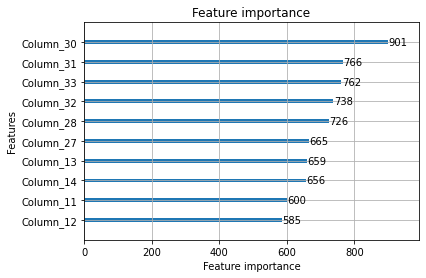

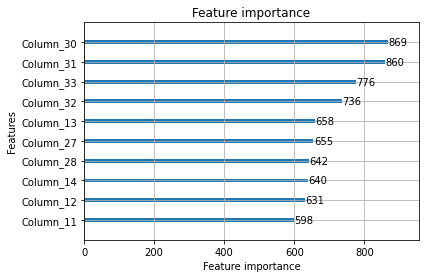

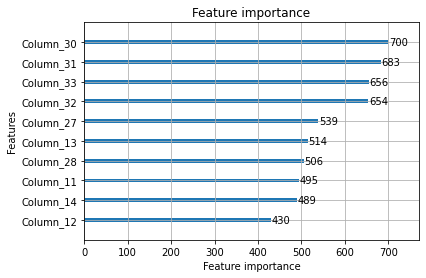

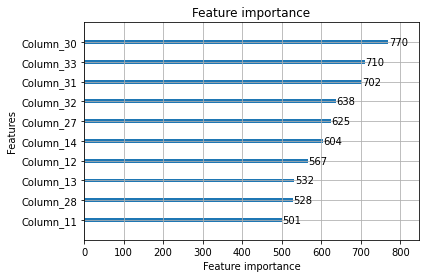

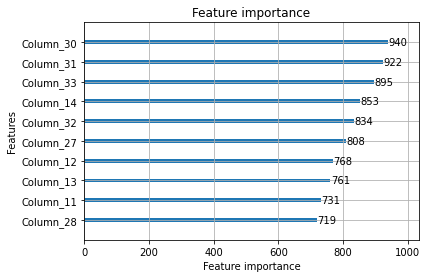

In [42]:
from sklearn.model_selection import KFold, StratifiedKFold
test_preds_1 = []
test_preds_2 = []

kf = StratifiedKFold(n_splits=5, shuffle=True) # KFold

for fold, (train_idx, test_idx) in enumerate(kf.split(xtrain_norm, train_y)):
    X_train, X_test = xtrain_norm[train_idx], xtrain_norm[test_idx]
    y_train, y_test = train_y.iloc[train_idx], train_y.iloc[test_idx]
    train_dataset = lgb.Dataset(X_train, y_train)
    val_dataset = lgb.Dataset(X_test, y_test)
    model = lgb.train(params = lgbm_params, 
                    train_set = train_dataset, 
                    valid_sets = [train_dataset, val_dataset], 
                    num_boost_round = 1000, 
                    callbacks=[lgb.early_stopping(stopping_rounds=100)],
                    verbose_eval = 50)
    test_preds_1.append(model.predict(xtrain_norm).squeeze())
    test_preds_2.append(model.predict(test_norm).squeeze())
    lgb.plot_importance(model,max_num_features=10)

In [43]:
from mlxtend.evaluate import confusion_matrix
predictions = sum(test_preds_1)/5
classes = np.argmax(predictions, axis = 1)
print(classes)
y_true = train_y.squeeze()
confmat = confusion_matrix(y_true, classes)

print(confmat)

[2 0 2 ... 0 0 0]
[[38658   505  8950]
 [18637   805  8209]
 [18078   508 16588]]


In [44]:
train_acc = np.mean(classes == y_true)*100
train_acc

50.52461735383728

In [45]:
prediction_1 = sum(test_preds_2)/5
prediction_1

array([[0.42724567, 0.28975807, 0.28299626],
       [0.36437348, 0.30248419, 0.33314233],
       [0.43162778, 0.28491868, 0.28345354],
       ...,
       [0.27578527, 0.26639677, 0.45781796],
       [0.62706824, 0.23321973, 0.13971203],
       [0.32430312, 0.30417833, 0.37151855]])

In [46]:
submission = pd.concat([pd.DataFrame(testn['id']), pd.DataFrame(prediction_1, columns=['home', 'draw', 'away'])[['home', 'draw', 'away']]], axis=1)
submission.to_csv('/content/drive/MyDrive/7313Project/submission_lbgm.csv', index=False)